In [1]:
import os

try:
    snakemake
except NameError:
    from snakemk_util import load_rule_args
    
    os.chdir('../..')
    
    snakemake = load_rule_args(
        snakefile = os.getcwd() + "/workflow/Snakefile",
        rule_name = 'benchmark_lapa',
        root = '..',
    )

In [2]:
import matplotlib.pyplot as plt
import pyranges as pr
from lapa.result import LapaResult
from sklearn.metrics import precision_recall_curve, auc

In [3]:
result_long_g12 = LapaResult(snakemake.input['long_rna_gm12'])
result_quantseq = LapaResult(snakemake.input['quantseq'])
result_short = LapaResult(snakemake.input['short_rna'])

In [4]:
gr_long = pr.PyRanges(result_long_g12.read_apa('gm12878'))

In [5]:
gr_short = pr.PyRanges(result_short.read_apa('gm12878'))

In [6]:
gr_rep1 = pr.PyRanges(result_quantseq.read_apa('gm12878_rep1')
                      .drop_duplicates(['Chromosome', 'Start', 'End', 'Strand']))
gr_rep2 = pr.PyRanges(result_quantseq.read_apa('gm12878_rep2')
                      .drop_duplicates(['Chromosome', 'Start', 'End', 'Strand']))

In [7]:
def join_outer(gr1, gr2, suffix):
    df = gr1.join(gr2, strandedness='same', how='outer', slack=50, suffix=suffix).df
    
    df.loc[df['Start'] == -1, 'Start'] = df.loc[df['Start'] == -1, f'Start{suffix}']
    df.loc[df['End'] == -1, 'End'] = df.loc[df['End'] == -1, f'End{suffix}']
    df.loc[df['Strand'] == -1, 'Strand'] = df.loc[df['Strand'] == -1, f'Strand{suffix}']
       
    return pr.PyRanges(df)

In [8]:
gr = join_outer(gr_rep1[gr_rep1.tpm > 5], gr_rep2, '_rep')
gr = join_outer(gr, gr_long, '_long')
gr = join_outer(gr, gr_short, '_short')
df = gr.df

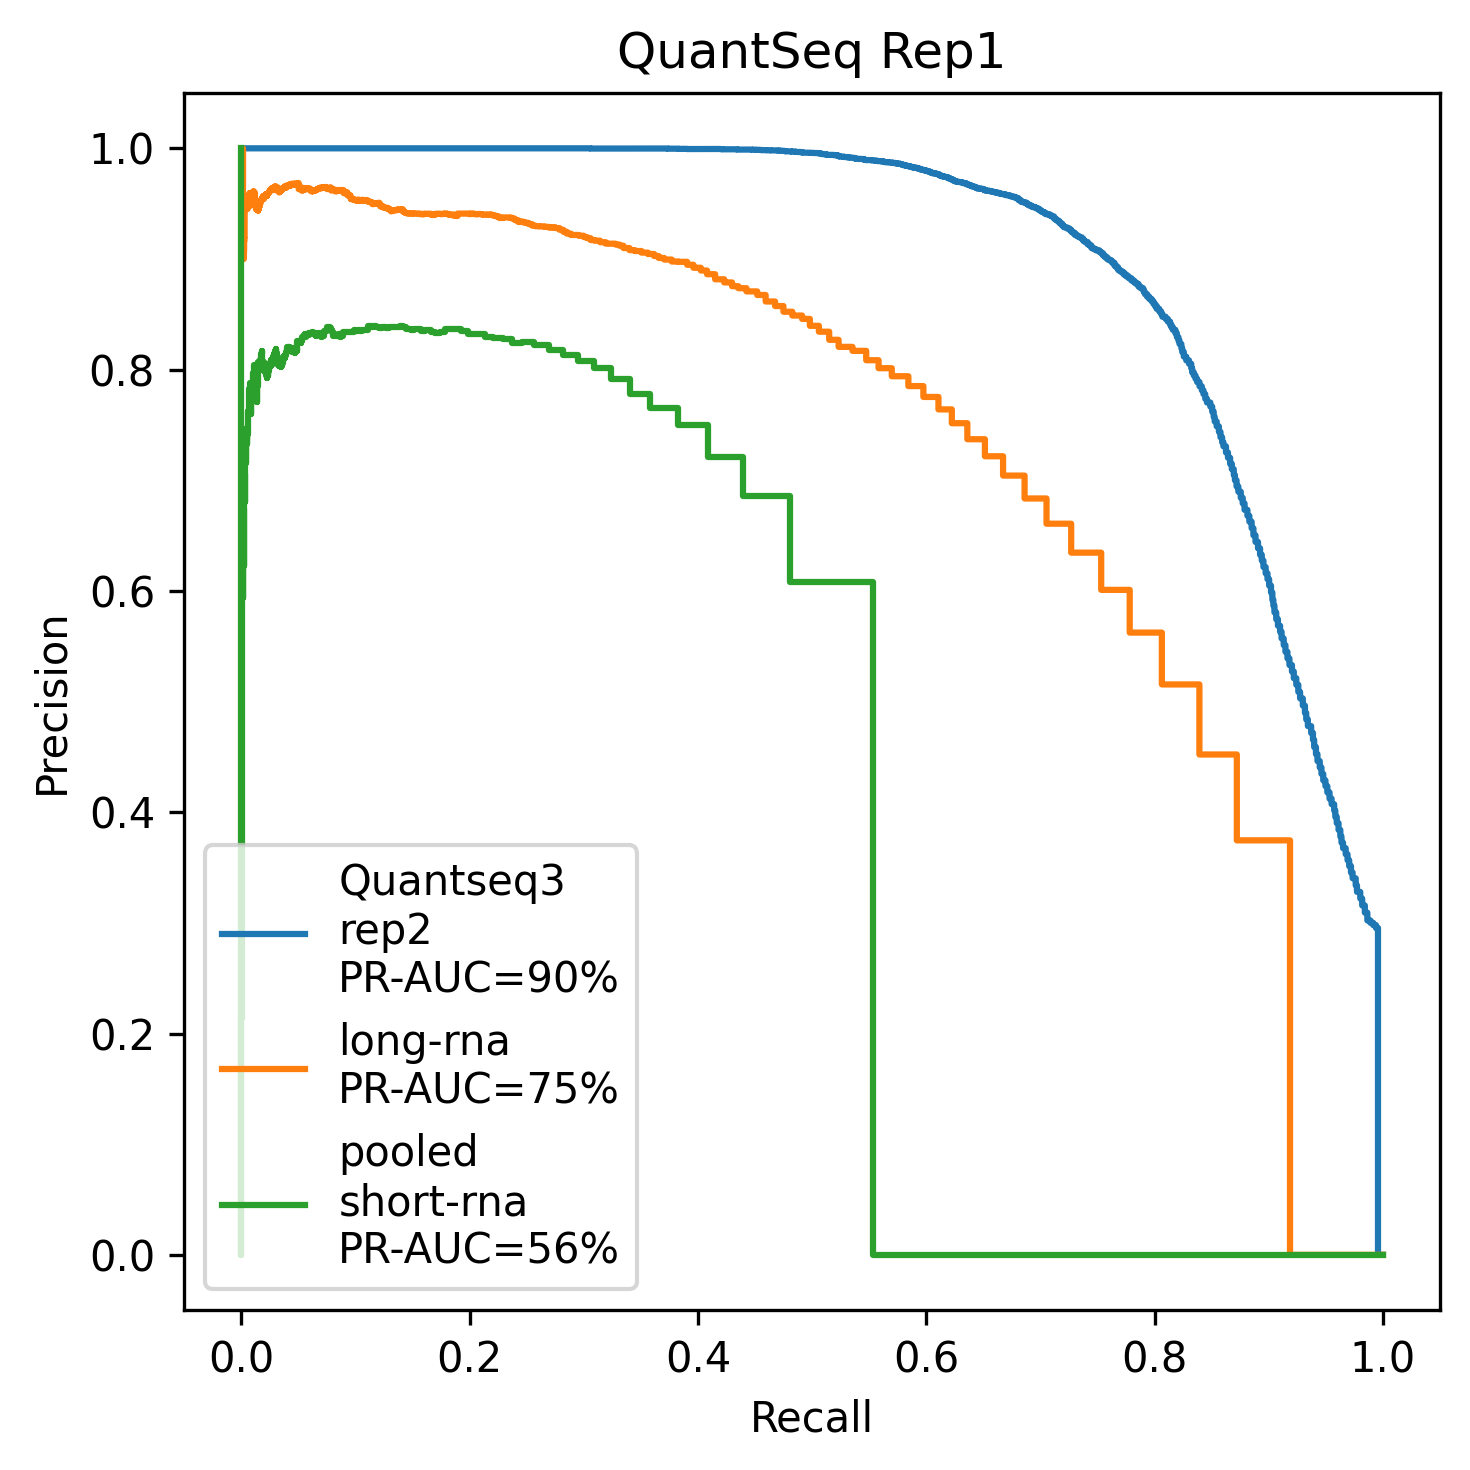

In [9]:
plt.figure(figsize=(5, 5), dpi=300)
plt.title('QuantSeq Rep1')

ground_truth = list((~(df['tpm'] == -1)).astype(int))
tpm_rep = df['tpm_rep']
tpm_long = df['tpm_long']
tpm_short = df['tpm_short']

for label, score in [('Quantseq3\nrep2', tpm_rep), ('long-rna', tpm_long), ('pooled\nshort-rna', tpm_short)]:
       
    prec, recall, threshold = precision_recall_curve(
        ground_truth, score, pos_label=1)
    prec[0] = 0
    label = f'{label}\nPR-AUC={int(auc(recall, prec) * 100)}%'
    plt.step(recall, prec, where='post', label=label)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc=3)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.tight_layout()
plt.savefig(snakemake.output['rep1'], bbox_inches = "tight")

In [10]:
gr = join_outer(gr_rep2[gr_rep2.tpm > 5], gr_rep1, '_rep')
gr = join_outer(gr, gr_long, '_long')
gr = join_outer(gr, gr_short, '_short')
df = gr.df

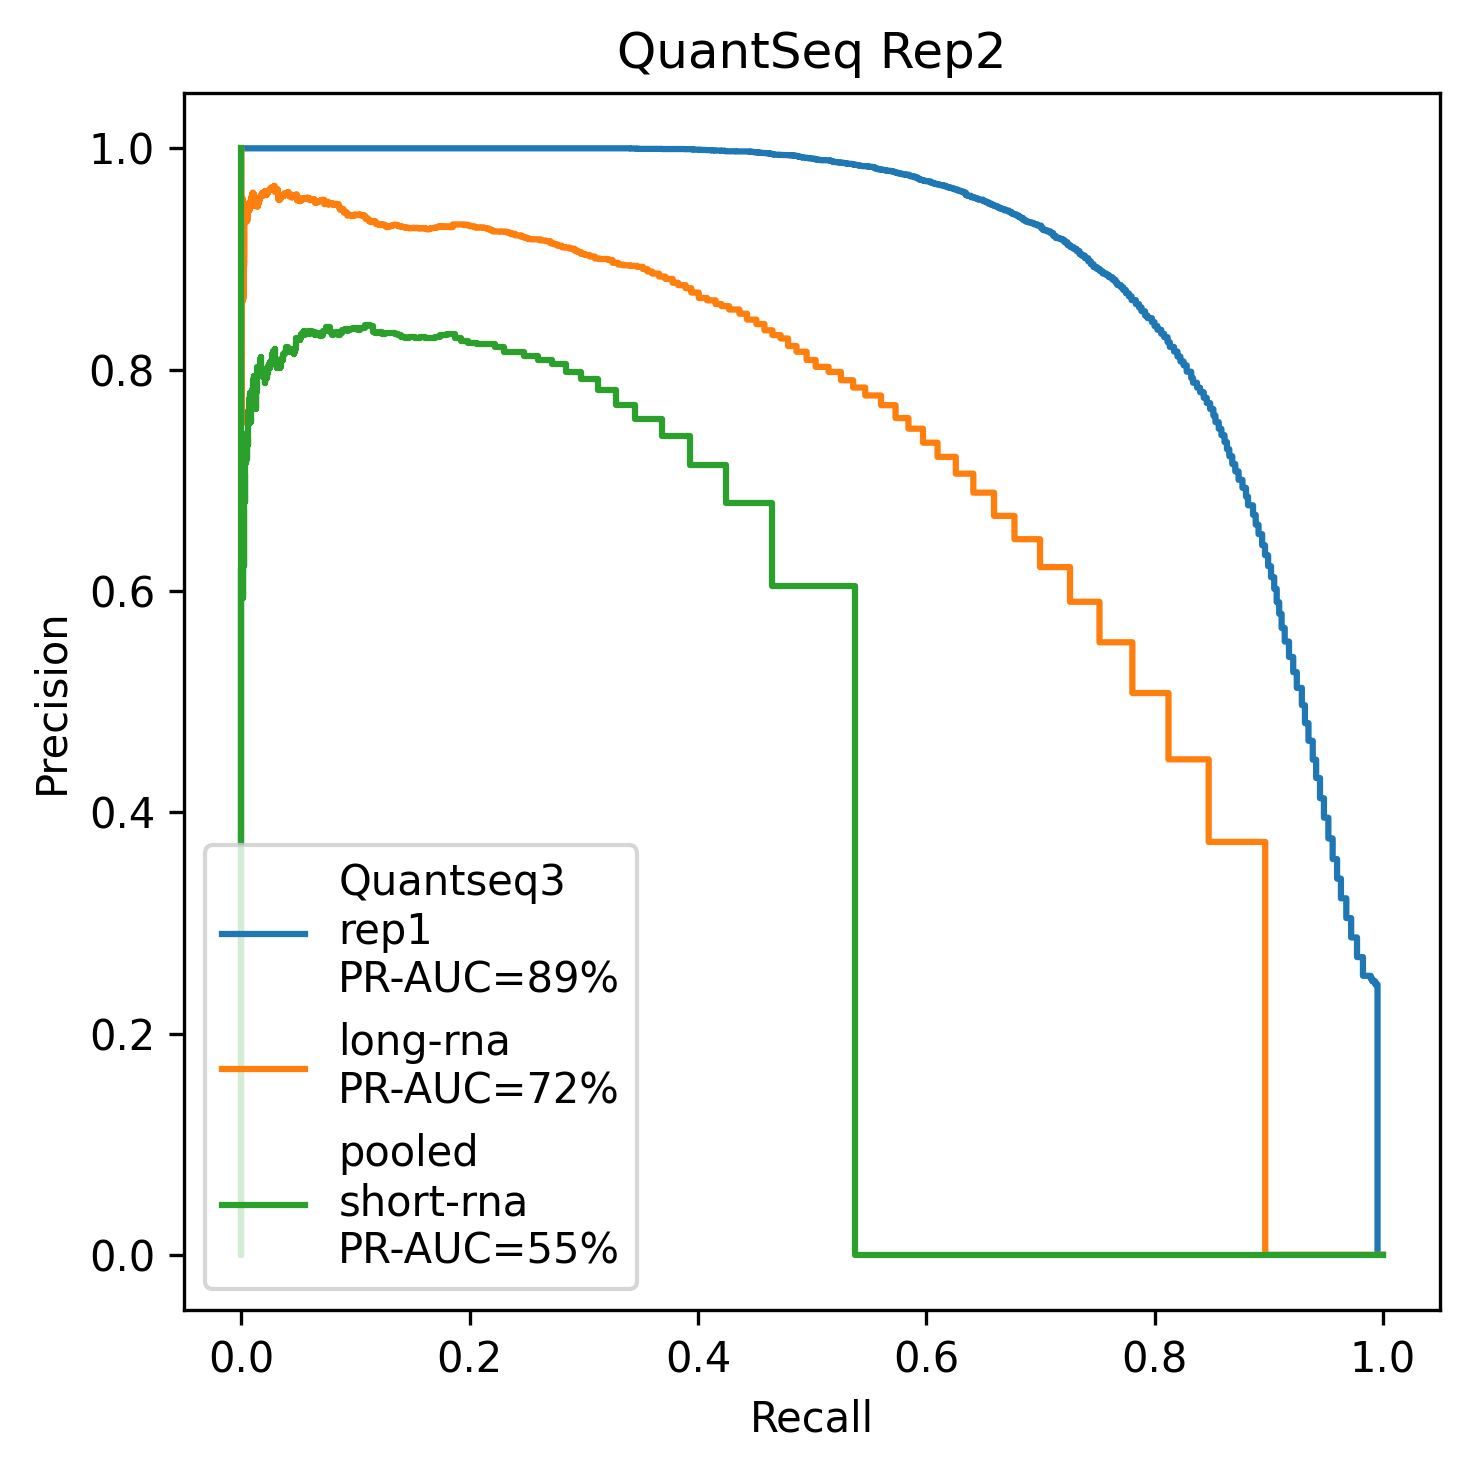

In [11]:
plt.figure(figsize=(5, 5), dpi=300)
plt.title('QuantSeq Rep2')

ground_truth = list((~(df['tpm'] == -1)).astype(int))
tpm_rep = df['tpm_rep']
tpm_long = df['tpm_long']
tpm_short = df['tpm_short']

for label, score in [('Quantseq3\nrep1', tpm_rep), ('long-rna', tpm_long), ('pooled\nshort-rna', tpm_short)]:
       
    prec, recall, threshold = precision_recall_curve(
        ground_truth, score, pos_label=1)
    prec[0] = 0
    label = f'{label}\nPR-AUC={int(auc(recall, prec) * 100)}%'
    plt.step(recall, prec, where='post', label=label)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc=3)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.tight_layout()
plt.savefig(snakemake.output['rep2'], bbox_inches = "tight")